Enter time step: .05
Diffusion Timescale:  500.0
Natural time scale: 4.88e+00
Solution is expected to be stable.


No handles with labels found to put in legend.


A critical temperature has reached 130 F


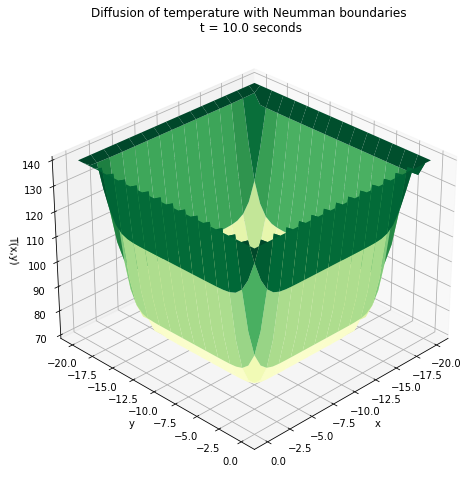

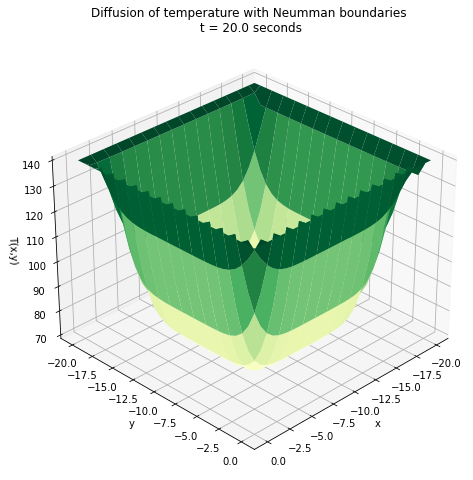

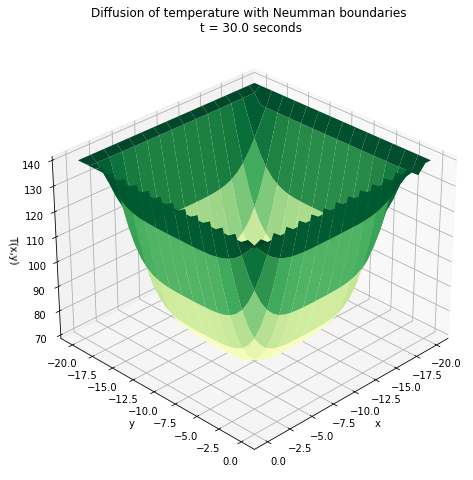

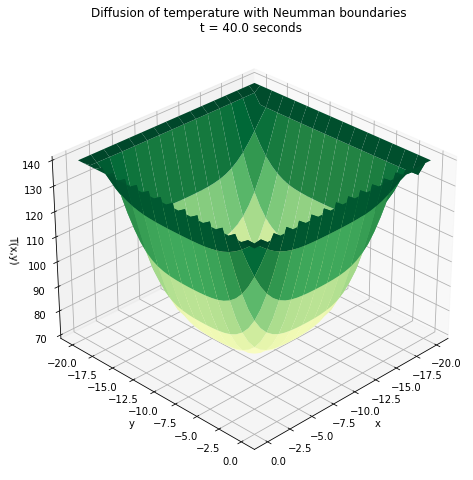

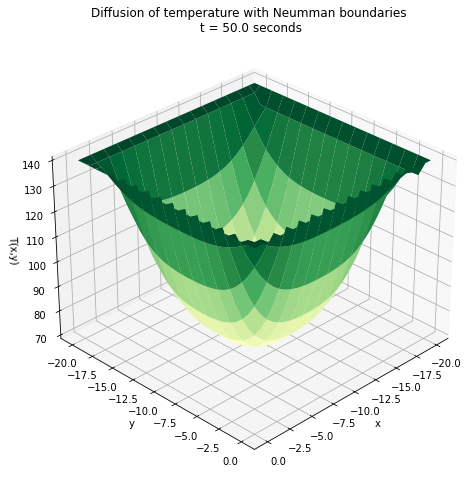

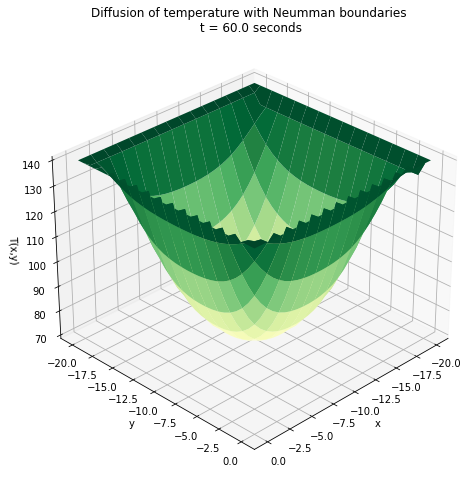

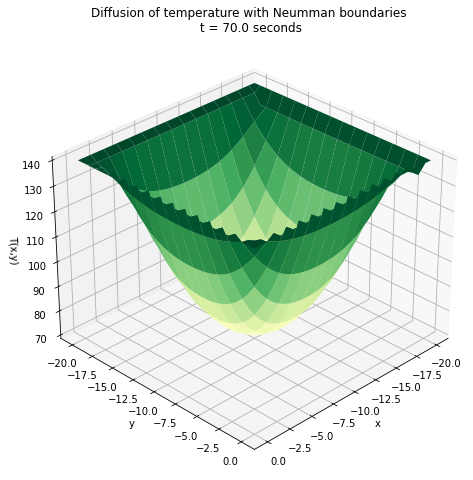

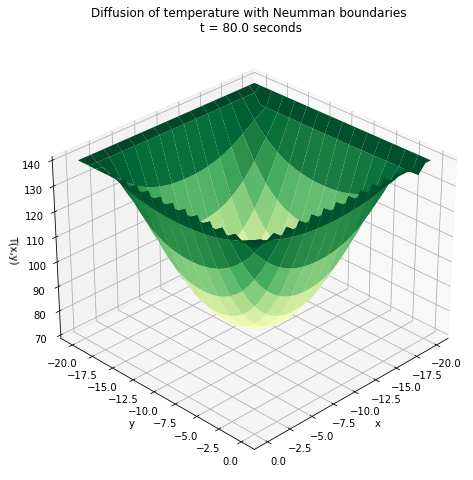

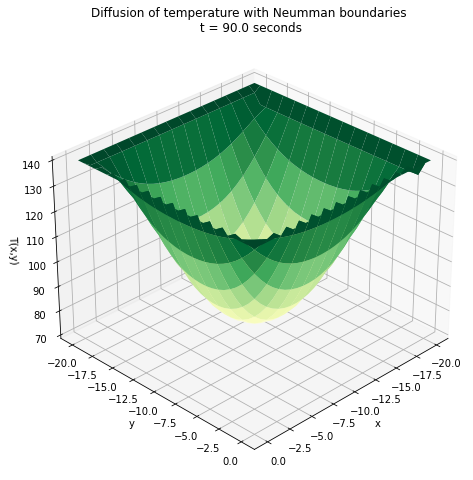

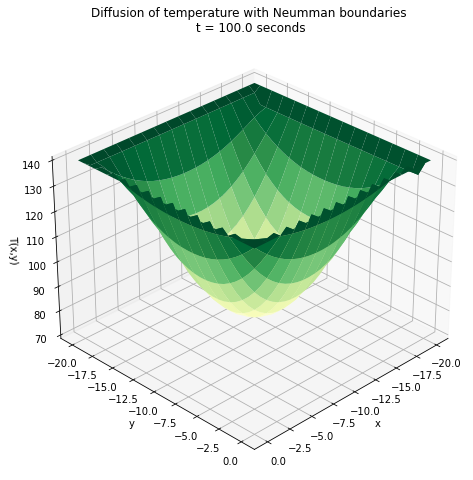

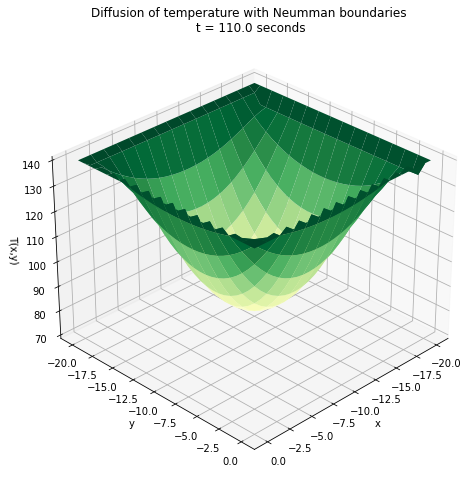

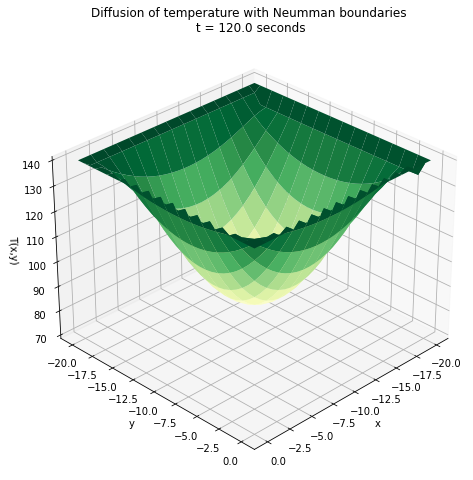

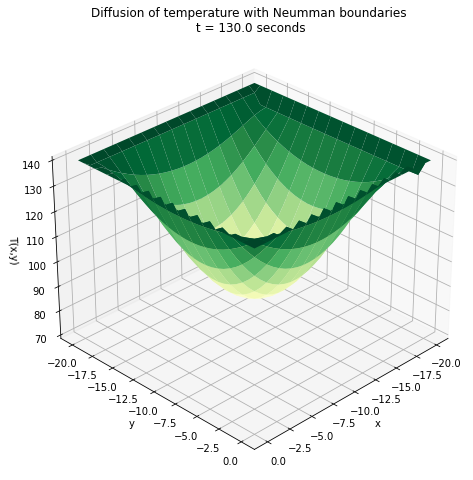

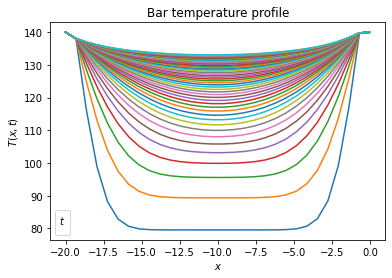

In [61]:
# dftcs - Program to solve the diffusion equation using Forward Time Centered Space (FTCS) scheme

# Set up configuration options and special features
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

large_width = 180
np.set_printoptions(precision=3,threshold=np.sys.maxsize,linewidth=large_width,suppress=False) 



# Initialize parameters (time step, grid spacing, etc.)
tau = eval(input('Enter time step: '))
N = 30
M = 30
L = 20  # The system extends from x = -L/2 to L/2
hx = L/(N-1)  # Grid size dx
hy = L/(M-1)
kappa = 0.1  # Diffusion coefficient
mu1 = kappa*tau/hx**2
mu2 = kappa*tau/hy**2
t_natural = np.sqrt(hx**2+hy**2)/(2*kappa)
t_diffuse = L**2/(8*kappa) #diffusion timescale T_d
print('Diffusion Timescale: ', t_diffuse)

print('Natural time scale: {0:.2e}'.format(np.sqrt(hx**2+hy**2)/(2*kappa)))

if mu1 < 0.5:
    print('Solution is expected to be stable.')
else:
    print('Warning! Solution is expected to be unstable. Consider smaller dt or larger dx.')


# Set initial and boundary conditions.
intr = 70 #Interior temperature of battery
tt = intr*np.ones((N,M))  # Temperature = 70 F at all interior points

#Dirichlet Boundary Conditions (Fixed Temperature at Endpoints)
ambient = 140 #Ambient temperature on surface of battery

#If side of battery is near engine, heat bath, coolant, etc. replace ambient manually
tt[:,M-1] = ambient
tt[:,0] = ambient
tt[0,:] = ambient
tt[N-1,:] = ambient
#v = velocity of the heat flux into battery
v1 = .0002 #m/s
v2 = .002
v3 = .0005
v4 = .006

# degrees CelsiusSet initial condition: delta function of high temperature in the center
# The boundary conditions are tt[0] = tt[N-1] = 0

# Set up loop and plot variables.
xplot = -np.arange(N)*hx   # Record the x scale for plots
yplot = -np.arange(M)*hy
iplot = 0  # Counter used to count plots
nstep = 10000  # Maximum number of iterations
nplots = 50  # Number of snapshots (plots) to take
plot_step = nstep/nplots  # Number of time steps between plots

# Loop over the desired number of time steps.
ttplot = np.empty((N,M,nplots))
tplot = np.empty(nplots)


## MAIN LOOP ##
for istep in range(nstep):
    #Neumann Boundary conditions - Heat flowing into battery to point nearest to edge
    tt[1,1:M-2] = tt[0,1:M-2] - hx*ambient*v1/kappa
    tt[N-2,1:M-2] = tt[N-1,1:M-2] - hx*ambient*v2/kappa
    tt[1:N-2,1] = tt[1:N-2,0] - hy*ambient*v3/kappa
    tt[1:N-2,M-2] = tt[1:N-2,M-1] - hy*ambient*v4/kappa
    
    
    # Note that the endpoints (boundary) is not updated.
    tt[1:N-1,1:M-1] = tt[1:N-1,1:M-1] + mu1*(tt[2:N,1:M-1] + tt[0:N-2,1:M-1] - 2*tt[1:N-1,1:M-1]) \
                + mu2*(tt[1:N-1,2:M] + tt[1:N-1,0:M-2] - 2*tt[1:N-1,1:M-1])

    # Periodically record temperature for plotting.
    if (istep + 1) % plot_step < 1:  # record data for plot every plot_step number of steps. Don't record first step.
        ttplot[:,:,iplot] = np.copy(tt)  # record a copy of tt(i) for plotting
        tplot[iplot] = (istep+1)*tau  # record time for plots
        iplot += 1
        

for k in range(nplots):
# Plot temperature versus x and y as a wire-mesh plot
    if ttplot[25,25,k] > 135:
        print('A critical temperature has reached 135 F')
        break
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    Xp, Yp = np.meshgrid(yplot, xplot)
    ax.plot_surface(Xp, Yp, ttplot[:,:,k], rstride=2, cstride=2, cmap='YlGn')
    angle = -315
    ax.view_init(30,angle)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim(intr,ambient)
    ax.set_zlabel(r'T(x,y)')
    ax.set_title('Diffusion of temperature with Neumman boundaries' + 
                 '\n t = ' + str(tplot[k]) + ' seconds')


# Plot 1D slices of the temperature distribution vs. space at short and long times
fig3, ax3 =plt.subplots()
ax3.set_title(r'Bar temperature profile')
ax3.plot(xplot, ttplot[:,25,:])
ax3.legend(title=r'$t$')
ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$T(x, t)$')


plt.show()


In [56]:
import imageio
from matplotlib import style

png_files =[]
for k in range(nplots):
# Plot temperature versus x and y as a wire-mesh plot
    filename = f'Animations/diffuse-{k}.png'
  
    png_files.append(filename)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    Xp, Yp = np.meshgrid(yplot, xplot)
    ax.plot_surface(Xp, Yp, ttplot[:,:,k], rstride=2, cstride=2, cmap='YlGn')
    angle = -315
    ax.view_init(30,angle)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim(intr,ambient)
    ax.set_zlabel(r'T(x,y)')
    ax.set_title('Diffusion of a delta spike')    
    plt.savefig(filename)
    plt.close()
with imageio.get_writer('2000.gif', mode='I') as writer:
    for filename in png_files:
        image = imageio.imread(filename)
        writer.append_data(image)

In [59]:
ttplot[1:N-2,1:M-2,k].any()

True